In [182]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from src.load import load

%load_ext autoreload
%matplotlib
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = load()
df.head(5)

==============================  Transform State  ===============================
[OK] Extracted data was load successfully
[INFO] Saving extracted state data
[OK] Directory is already exist
[OK] Data was saved sucessfully at ./data/transform/transform_with_label.csv


,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
37094,1,JUL_22_1,2025-07-22 13:17:40,2,2,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.70,0,3.639,0,2.342,0.002,0.6329,Bath_3
37095,2,JUL_22_1,2025-07-22 13:17:42,2,4,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.70,0,3.705,0,2.342,0.004,0.6329,Bath_3
37096,3,JUL_22_1,2025-07-22 13:17:44,2,6,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.71,0,3.702,0,2.342,0.006,0.6329,Bath_3
37097,4,JUL_22_1,2025-07-22 13:17:46,2,8,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.68,0,3.673,0,2.342,0.008,0.6329,Bath_3
37098,5,JUL_22_1,2025-07-22 13:17:49,2,10,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.69,0,3.668,0,2.342,0.010,0.6329,Bath_3


In [4]:
conductivity_df = df[['index', 'run_id', 'conductivity']]
conductivity_df = conductivity_df.pivot(index='run_id', columns='index', values='conductivity').reset_index()
conductivity_df = conductivity_df.set_index('run_id')
conductivity_df = conductivity_df.apply(lambda row: row.fillna(row.mean()), axis=1).reset_index()
conductivity_df.columns.name = None
# raw_data = conductivity_df.values
conductivity_df.head(5)

,run_id,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,JUL_22_1,56.32,56.32,56.17,56.17,56.17,56.17,56.17,56.24,56.24,...,56.17,56.11,56.10,56.10,56.10,56.03,56.11,56.32,56.179983,56.179983
1,JUL_22_2,56.11,56.10,56.11,56.39,56.10,56.17,56.39,56.17,56.17,...,56.03,56.03,56.25,56.25,56.25,56.24,56.32,56.10,56.110000,56.320000
2,JUL_22_3,58.28,58.34,58.36,58.28,58.22,58.14,58.22,58.14,58.14,...,58.14,58.36,58.34,58.14,58.14,58.14,58.14,58.14,58.187772,58.187772
3,JUL_22_4,55.89,55.97,55.97,56.03,55.97,56.03,55.97,55.97,55.97,...,55.75,55.83,55.81,55.81,55.75,55.75,55.75,55.75,55.830000,55.854281
4,JUL_22_5,55.89,56.03,55.67,55.89,55.75,55.72,55.89,55.75,55.89,...,55.75,55.61,55.69,55.61,55.55,55.56,55.55,55.53,55.610000,55.724047


In [5]:
anomaly_conductivity_df = df[['index', 'run_id', 'Anomaly C']]
anomaly_conductivity_df = anomaly_conductivity_df.pivot(index='run_id', columns='index', values='Anomaly C').reset_index()
anomaly_conductivity_df = anomaly_conductivity_df.set_index('run_id')
anomaly_conductivity_df = anomaly_conductivity_df.apply(lambda row: row.fillna(row.mean()), axis=1).reset_index()
anomaly_conductivity_df.columns.name = None
# raw_data = anomaly_conductivity_df.values
anomaly_conductivity_df.head(5)

/var/folders/y8/pcljvbld7z139vcsnrybdnt80000gn/T/ipykernel_29042/3053356357.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  anomaly_conductivity_df = anomaly_conductivity_df.apply(lambda row: row.fillna(row.mean()), axis=1).reset_index()


,run_id,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,JUL_22_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JUL_22_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JUL_22_3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,JUL_22_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JUL_22_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
raw_df = pd.concat([conductivity_df, anomaly_conductivity_df], axis=1)
raw_data = raw_df.values
raw_df.head(5)


,run_id,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,JUL_22_1,56.32,56.32,56.17,56.17,56.17,56.17,56.17,56.24,56.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JUL_22_2,56.11,56.10,56.11,56.39,56.10,56.17,56.39,56.17,56.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JUL_22_3,58.28,58.34,58.36,58.28,58.22,58.14,58.22,58.14,58.14,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,JUL_22_4,55.89,55.97,55.97,56.03,55.97,56.03,55.97,55.97,55.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JUL_22_5,55.89,56.03,55.67,55.89,55.75,55.72,55.89,55.75,55.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data = raw_data[:, 1:600].astype(float)
# skip one for duplicate run_id column
labels = raw_data[:, 601:].astype(float)
print(f"Data shape: {data.shape}")
print(f"Label shape: {labels.shape}")

Data shape: (15, 599)
Label shape: (15, 599)


In [137]:
flatten_df = data.flatten()
flatten_label_df = labels.flatten()

In [185]:
pd.DataFrame(flatten_df)

,0
0,56.320000
1,56.320000
2,56.170000
3,56.170000
4,56.170000
...,...
8980,57.010000
8981,56.800000
8982,56.800000
8983,57.010000


In [163]:
def create_sequences(data, sequence_length, step=1):
    """
    Converts a long time series into a dataset of smaller windows.
    
    Args:
        data (np.array): Your time series data, shape [total_length, num_features]
        sequence_length (int): The size of each window (e.g., 64)
        step (int): How many time steps to slide the window. 
                    (step=1 means max overlap)
    """
    X = []
    y = [] # We use X for both input and target in an autoencoder
    
    for i in range(0, len(data) - sequence_length, step):
        window = data[i:(i + sequence_length)]
        X.append(window)
        y.append(window) # The target is the same as the input
        
    return np.array(X), np.array(y)

In [242]:
# 1. Define parameters
SEQUENCE_LENGTH = 64
NUM_FEATURES = 1
BATCH_SIZE = 32

# (Assuming 'flatten_df' is your long, continuous numpy array)
# (If it's a DataFrame, use flatten_df.values)

# 2. Split your data CHRONOLOGICALLY first
split_idx = int(len(flatten_df) * 0.8)
train_data_long = flatten_df[:split_idx]
val_data_long = flatten_df[split_idx:]

# 3. Fit the scaler ONLY on the training data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data_long)

# 4. Transform the validation data using the SAME scaler
val_data_normalized = scaler.transform(val_data_long)

# 5. NOW, create your windows from the continuous, normalized chunks
X_train, y_train = create_sequences(train_data_normalized, SEQUENCE_LENGTH)
X_val, y_val = create_sequences(val_data_normalized, SEQUENCE_LENGTH)

# 6. Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# 7. Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training windows: {X_train.shape}")
print(f"Validation windows: {X_val.shape}")

Training windows: (7124, 64, 1)
Validation windows: (1733, 64, 1)


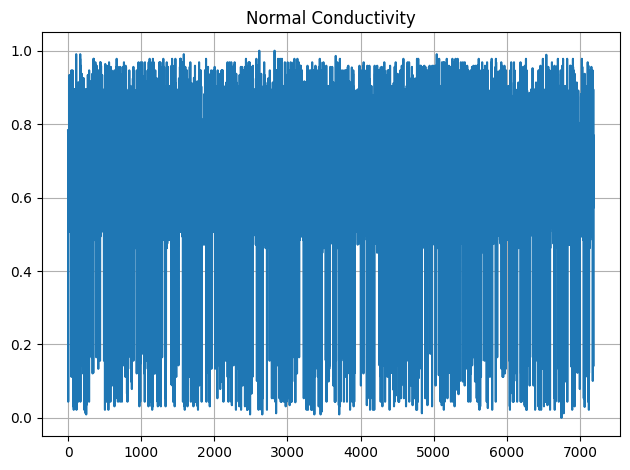

In [243]:
plt.grid()

plt.plot(np.arange(7188), train_data)
plt.title("Normal Conductivity")
plt.tight_layout()
plt.show()

In [244]:
class VAE(nn.Module):

    def __init__(self, input_dim=599, hidden_dim=128, latent_dim=64, device=device):
        super(VAE, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, log_var):
        epsilon = torch.randn_like(log_var).to(device)
        z = mean + torch.exp(log_var/2) * epsilon
        return z
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [ ]:
# def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.mse_loss(x_hat, x ,reduction='sum')
#     KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
#     return reproduction_loss + KLD

In [245]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # 1. Reconstruction Loss (using MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # 2. KL Divergence
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Return the *balanced* loss
    return recon_loss + (beta * kld)

In [246]:
class ConvVAE(nn.Module):
    def __init__(self, num_features=1, sequence_length=64, latent_dim=8):
        """
        A 1D Convolutional VAE for time series.
        (Version 2 - Corrected Shape Calculation)
        """
        super(ConvVAE, self).__init__()
        
        self.num_features = num_features
        self.sequence_length = sequence_length
        self.latent_dim = latent_dim

        # --- Encoder ---
        # We define the conv layers separately from the flatten
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(num_features, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # --- NEW: Auto-calculate shapes ---
        # We do one dummy pass to find the *exact* output shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_features, sequence_length)
            
            # Get the shape *after* convs, *before* flatten
            encoder_output = self.encoder_conv(dummy_input)
            
            # This is the shape we need to un-flatten to
            # e.g., (64, 8)
            self.unflatten_shape = encoder_output.shape[1:] 
            
            # This is the total size after flattening
            # e.g., 64 * 8 = 512
            self.flattened_size = torch.numel(encoder_output)
            
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # --- Decoder ---
        self.decoder_project = nn.Linear(latent_dim, self.flattened_size)
        
        self.decoder = nn.Sequential(
            # We use the auto-calculated channel size (self.unflatten_shape[0])
            nn.ConvTranspose1d(self.unflatten_shape[0], 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, num_features, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """
        x input shape: [batch_size, sequence_length, num_features]
        """
        
        x = x.permute(0, 2, 1)
        
        # --- Encode ---
        h_conv = self.encoder_conv(x)
        # We flatten manually using the start_dim=1
        h = torch.flatten(h_conv, start_dim=1) 
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # --- Sample (or use mu) ---
        if self.training:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu 

        # --- Decode ---
        recon_h = self.decoder_project(z)
        
        # Reshape back to the 3D shape we stored
        recon_h = recon_h.view(-1, *self.unflatten_shape) 
        
        recon_x = self.decoder(recon_h)
        
        recon_x = recon_x.permute(0, 2, 1)

        return recon_x, mu, logvar

In [249]:
# model = VAE(input_dim=60, hidden_dim=32, latent_dim=16, device=device)
model = ConvVAE(
    num_features=NUM_FEATURES,
    sequence_length=SEQUENCE_LENGTH,
    latent_dim=16  # You can tune this
).to(device)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
train_losses = []
val_losses = []

epochs = 100
beta = 0.01

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    #----- Training Loop -----#
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        recon_x, mu, logvar = model(batch_x)
        loss = vae_loss(recon_x, batch_y, mu, logvar, beta=beta) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch_x.size(0)

    # Calculate loss using the manual sample count
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    #----- validation -----
    model.eval()
    running_validate_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            recon_x, mu, logvar = model(batch_x)
            loss = vae_loss(recon_x, batch_y, mu, logvar)
            
            running_validate_loss += loss.item() * batch_x.size(0)
            
    # Calculate loss using the manual sample count
    epoch_val_loss = running_validate_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch:03d} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

Epoch 000 | Train Loss: 0.068055 | Val Loss: 1.221875
Epoch 001 | Train Loss: 0.018849 | Val Loss: 1.239965
Epoch 002 | Train Loss: 0.012394 | Val Loss: 1.032465
Epoch 003 | Train Loss: 0.010869 | Val Loss: 0.934297
Epoch 004 | Train Loss: 0.009981 | Val Loss: 0.815436
Epoch 005 | Train Loss: 0.009340 | Val Loss: 0.785003
Epoch 006 | Train Loss: 0.008779 | Val Loss: 0.776444
Epoch 007 | Train Loss: 0.008260 | Val Loss: 0.718775
Epoch 008 | Train Loss: 0.007765 | Val Loss: 0.644088
Epoch 009 | Train Loss: 0.007288 | Val Loss: 0.599581
Epoch 010 | Train Loss: 0.006715 | Val Loss: 0.516126
Epoch 011 | Train Loss: 0.006181 | Val Loss: 0.467802
Epoch 012 | Train Loss: 0.005536 | Val Loss: 0.380819
Epoch 013 | Train Loss: 0.004946 | Val Loss: 0.335143
Epoch 014 | Train Loss: 0.004481 | Val Loss: 0.286988
Epoch 015 | Train Loss: 0.004227 | Val Loss: 0.275071
Epoch 016 | Train Loss: 0.004018 | Val Loss: 0.253107
Epoch 017 | Train Loss: 0.003878 | Val Loss: 0.243125
Epoch 018 | Train Loss: 0.00

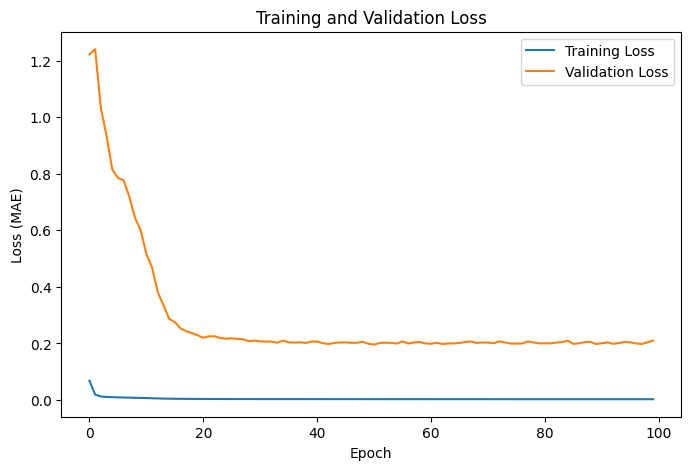

In [250]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

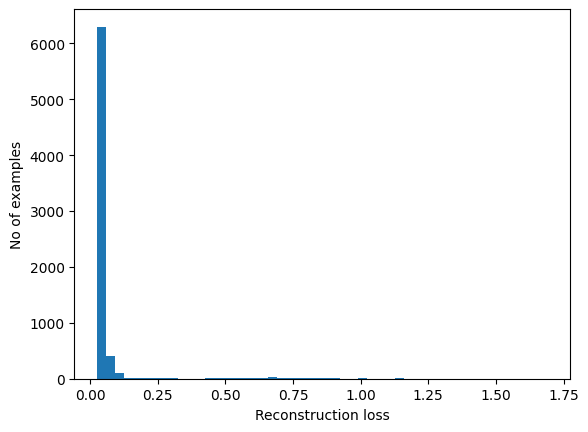

In [251]:
# 1. Get the loss function that returns loss *per sample*
def vae_loss_per_sample(recon_x, x, mu, logvar):
    # Use reduction='none' to get per-element loss
    recon_loss_all = F.mse_loss(recon_x, x, reduction='none')
    # Sum across the sequence and features (dims 1 and 2)
    recon_loss = torch.sum(recon_loss_all, dim=[1, 2])
    
    # KLD per sample
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    
    return recon_loss + (beta * kld) # Use the same 'beta' you used in training

# 2. Get all your training data as a single tensor
# (You might need to concatenate your train_loader batches if it's too big)
# Assuming X_train_tensor is your full training data [num_samples, seq_len, features]
X_train_tensor = train_dataset.tensors[0].to(device)

# 3. Put model in eval mode and get losses
model.eval()
with torch.no_grad():
    recon_x, mu, logvar = model(X_train_tensor)
    sample_losses = vae_loss_per_sample(recon_x, X_train_tensor, mu, logvar)
    test_losses = sample_losses.cpu().numpy()

# 4. Plot your histogram
plt.hist(test_losses, bins=50)
plt.xlabel("Reconstruction loss")
plt.ylabel("No of examples")
plt.show()

In [318]:
import numpy as np

# 'test_losses' is the numpy array from your previous step
threshold = np.quantile(test_losses, 0.85) 

print(f"Anomaly Threshold (99th percentile): {threshold:.4f}")

Anomaly Threshold (99th percentile): 0.0536


In [324]:
# threshold = np.max(test_losses)

print(np.mean(test_losses))
# print(f"Anomaly Threshold (Max loss): {threshold:.4f}")

0.06728375


In [ ]:
# 1. Get losses for your validation data
#    (Make sure to use the same 'vae_loss_per_sample' function)
# X_val_tensor = val_dataset.tensors[0].to(device)

# model.eval()
# with torch.no_grad():
#     recon_x, mu, logvar = model(X_val_tensor)
#     val_losses = vae_loss_per_sample(recon_x, X_val_tensor, mu, logvar)
#     val_losses = val_losses.cpu().numpy()

# # 2. Compare losses to the threshold
# # This creates a boolean array (True/False)
# is_anomaly = val_losses > threshold

# print(f"Total validation samples: {len(val_losses)}")
# print(f"Anomalies found: {np.sum(is_anomaly)}")

# # 3. Get the indices (the "when") of the anomalies
# anomaly_indices = np.where(is_anomaly)[0]
# print(f"Indices of anomalies: {anomaly_indices}")

Total validation samples: 1733
Anomalies found: 54
Indices of anomalies: [1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152
 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192]


In [319]:
X_train_tensor = train_dataset.tensors[0].to(device)

model.eval()
with torch.no_grad():
    recon_x, mu, logvar = model(X_train_tensor)
    val_losses = vae_loss_per_sample(recon_x, X_train_tensor, mu, logvar)
    val_losses = val_losses.cpu().numpy()

# 2. Compare losses to the threshold
# This creates a boolean array (True/False)
is_anomaly = val_losses > threshold

print(f"Total validation samples: {len(val_losses)}")
print(f"Anomalies found: {np.sum(is_anomaly)}")

# 3. Get the indices (the "when") of the anomalies
anomaly_indices = np.where(is_anomaly)[0]
print(f"Indices of anomalies: {anomaly_indices}")

Total validation samples: 7124
Anomalies found: 1069
Indices of anomalies: [1135 1136 1137 ... 5388 5389 5390]


In [ ]:
# Get the un-normalized, original validation data
# val_df = val_data_long.copy()

# validation_df = pd.DataFrame(val_df)
# validation_df = validation_df.rename(columns={0:'conductivity'})
# # Create a new column, initializing all rows as "not anomalous"
# validation_df['is_anomaly'] = False

# # Loop through each anomalous window's STARTING index
# for start_index in anomaly_indices:
#     # Calculate the end index for this window
#     end_index = start_index + SEQUENCE_LENGTH
    
#     # Mark all rows within this window as anomalous
#     # We use .iloc to select rows by their integer position
#     validation_df.iloc[start_index : end_index, validation_df.columns.get_loc('is_anomaly')] = True

# # See how many rows are now marked as anomalies
# print(validation_df['is_anomaly'].value_counts())

# # Create a new DataFrame containing only the anomalous data points
# anomalies_df = validation_df[validation_df['is_anomaly'] == True]

# print("\n--- Anomalous Data ---")
# print(anomalies_df.head())

is_anomaly
False    1680
True      117
Name: count, dtype: int64

--- Anomalous Data ---
      conductivity  is_anomaly
1139      0.981132        True
1140      0.977987        True
1141      0.968553        True
1142      0.977987        True
1143      0.946541        True


In [320]:
# Get the un-normalized, original validation data
val_df = train_data_long.copy()

validation_df = pd.DataFrame(val_df)
validation_df = validation_df.rename(columns={0:'conductivity'})
# Create a new column, initializing all rows as "not anomalous"
validation_df['is_anomaly'] = False

# Loop through each anomalous window's STARTING index
for start_index in anomaly_indices:
    # Calculate the end index for this window
    end_index = start_index + SEQUENCE_LENGTH
    
    # Mark all rows within this window as anomalous
    # We use .iloc to select rows by their integer position
    validation_df.iloc[start_index : end_index, validation_df.columns.get_loc('is_anomaly')] = True

# See how many rows are now marked as anomalies
print(validation_df['is_anomaly'].value_counts())

# Create a new DataFrame containing only the anomalous data points
anomalies_df = validation_df[validation_df['is_anomaly'] == True]

print("\n--- Anomalous Data ---")
print(anomalies_df.head())

is_anomaly
False    5407
True     1781
Name: count, dtype: int64

--- Anomalous Data ---
      conductivity  is_anomaly
1135      0.572327        True
1136      0.572327        True
1137      0.572327        True
1138      0.572327        True
1139      0.595912        True


In [321]:
validation_df

,conductivity,is_anomaly
0,0.595912,False
1,0.595912,False
2,0.572327,False
3,0.572327,False
4,0.572327,False
...,...,...
7183,0.716981,False
7184,0.750164,False
7185,0.750164,False
7186,0.750164,False


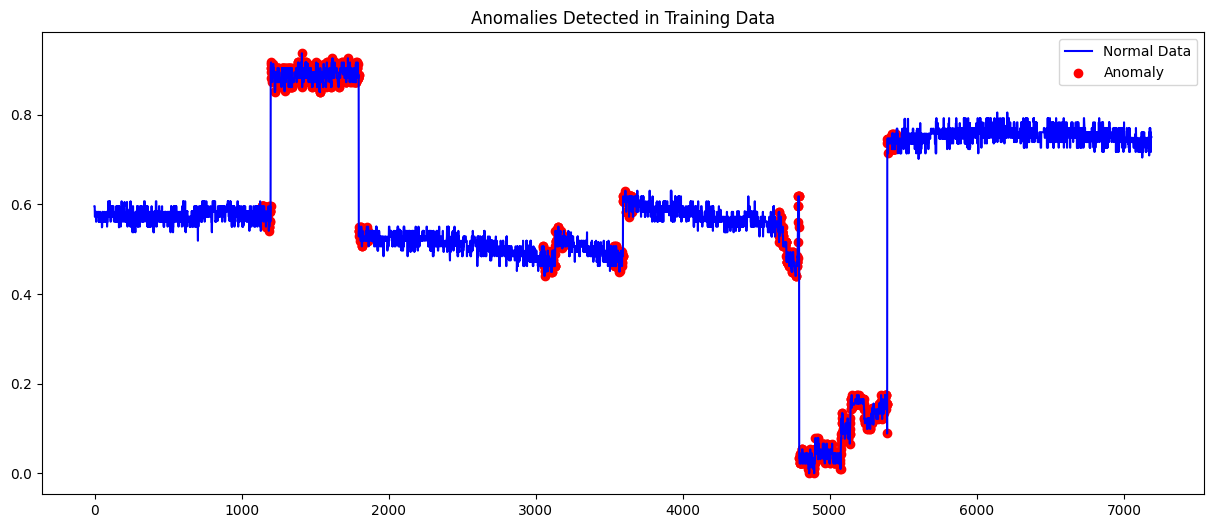

In [325]:
import matplotlib.pyplot as plt

# Assuming your main sensor data is in a column named 'sensor_value'
# Replace 'sensor_value' with your actual column name
data_column_name = 'sensor_value' 

# Plot the whole validation series
plt.figure(figsize=(15, 6))
plt.plot(validation_df.index, validation_df['conductivity'], label='Normal Data', color='blue')

# Plot just the anomalous points on top
plt.scatter(
    anomalies_df.index, 
    anomalies_df['conductivity'], 
    color='red', 
    label='Anomaly'
)

plt.legend()
plt.title("Anomalies Detected in Training Data")
plt.show()

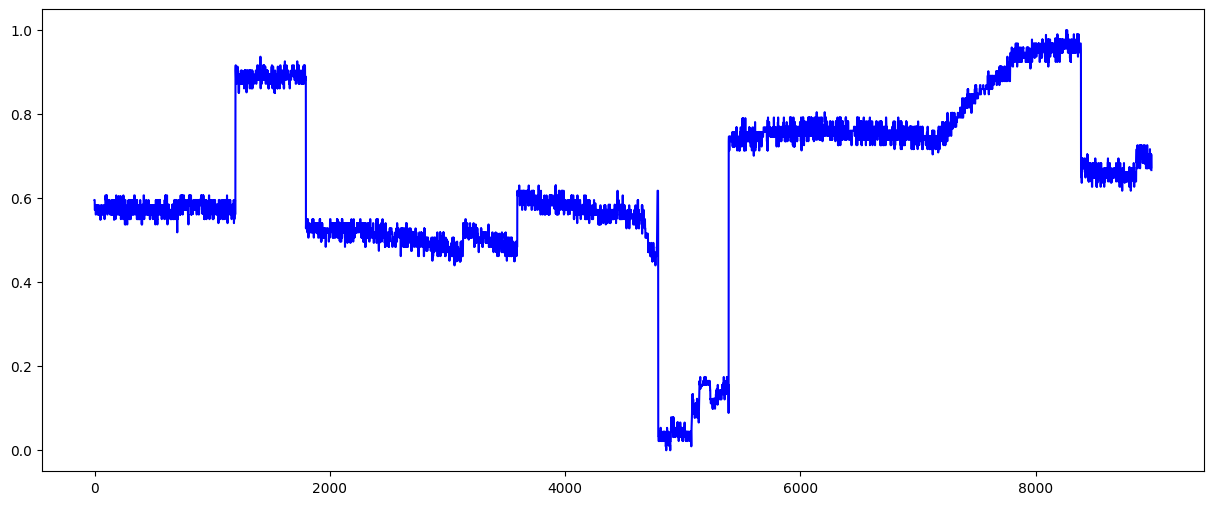

In [326]:
check_df = pd.DataFrame(flatten_df)
check_df = check_df.rename(columns={0:'conductivity'})
plt.figure(figsize=(15, 6))
plt.plot(check_df.index, check_df['conductivity'], label='Normal Data', color='blue')

In [327]:
# Save the model's state_dict
PATH = "convVAE_1.0.pth"
torch.save(model.state_dict(), PATH)